<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/generative_dl/deepdream_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepDream with Inception V3

This is like looking into what's present in a ConvNet Filter, being precise this consist in running a ConvNet in reverse: doing a gradient ascent on the input with the intention to maximaze the activation of a specific filter in an upper layer of the ConvNet.

Upload the image to deal with and also set the sufix of the result

In [17]:
from keras import utils

base_image_path = utils.get_file('brock.jpg', 'https://cdn.images.express.co.uk/img/dynamic/4/590x/secondary/Brock-Lesnar-1310950.jpg')
result_prefix = 'brock_dream'

57344/55412 [===============================] - 0s 2us/step


Here we define the DeepDream configuration by setting the quantity to achieve during the maximization process.


With the later hyper parameters we achieve the effects.
1. `step` defines the Gradient Ascent step size.
1. `num_octave` the number of scales to run gradient ascent.
1. `octave_scale` the size ratio between scales.
1. `iterations` the number of ascent steps per scale.

In [19]:
layers_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5
}

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 16.0

The target image is the following

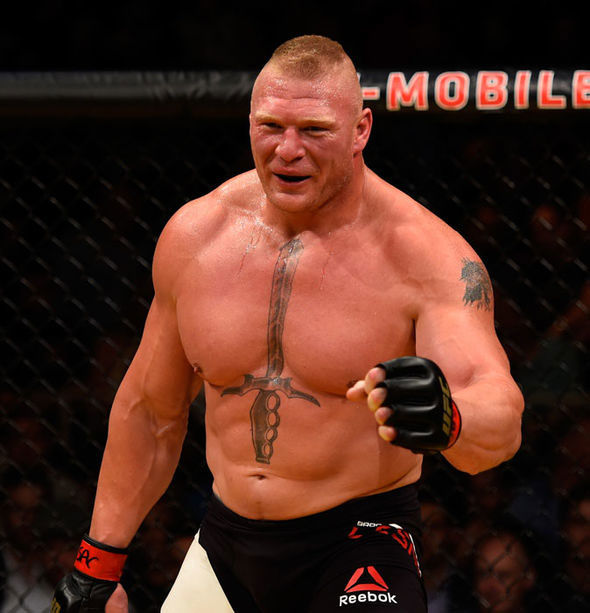

In [18]:
from IPython.display import Image, display

display(Image(base_image_path))

Now we define some preprocessing utilities.

- The first function formats the image into the appropiate shape to feed into the network
- The next is to pull from a `NumPy` Array into an actual image object.

In [4]:
import numpy as np
from keras.preprocessing import image as preprocessing_image

def preprocess_image(image_path):
  img = preprocessing_image.load_img(image_path)
  img = preprocessing_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)

  return img

def deprocess_image(x):
  x = x.reshape(x.shape[1], x.shape[2], 3)
  x /= 2.0
  x += 0.5
  x *= 255.0

  # Convert to uint8 and clip to a valid range [0, 255]
  x = np.clip(x, 0, 255).astype("uint8")

  return x

##Compute the Deep Dream loss

The first step is to build a feature extraction model which will retrieve the activations of the target layers given the input img.

In [5]:
from keras.applications import inception_v3
from keras import Model
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
output_dict = dict([(layer.name, layer.output) for layer in [
                   model.get_layer(name) for name in layers_contributions.keys()]])

# Here we set a model that retrieves the activation values for the given target layers
feature_extractor = Model(inputs=model.inputs, outputs=output_dict)

87916544/87910968 [==============================] - 2s 0us/step


In [6]:
import tensorflow as tf

def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())

  for name in features.keys():
    coeff = layers_contributions[name]
    activation = features[name]

    # Here we avoid border artifacts by omiting border pixels (see the shape)
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
    loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling

  return loss

##Set up the gradient ascent loop for 1/8

In [7]:
def gradient_ascent_step(img, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img)

  grads = tape.gradient(loss, img)
  # Normalize the gradients
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
  img += learning_rate * grads

  return loss, img

def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, img = gradient_ascent_step(img, learning_rate)
    
    if max_loss is not None and loss > max_loss:
      break
    
    print("Loss value at step %d: %.2f" % (i, loss))

  return img

##Running the training loop by iterating over different octaves

In [20]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img_copy = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
  print(f'Processing octave {i} with shape {shape}')
  img_copy = tf.image.resize(img_copy, shape)
  img_copy = gradient_ascent_loop(img_copy, iterations=iterations, learning_rate=step, max_loss=max_loss)

  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img_copy += lost_detail
  shrunk_original_img= tf.image.resize(original_img, shape)

preprocessing_image.save_img(result_prefix + '.png', deprocess_image(img_copy.numpy()))

Processing octave 0 with shape (312, 301)
Loss value at step 0: 2.04
Loss value at step 1: 2.53
Loss value at step 2: 3.22
Loss value at step 3: 3.99
Loss value at step 4: 4.70
Loss value at step 5: 5.44
Loss value at step 6: 6.17
Loss value at step 7: 6.89
Loss value at step 8: 7.63
Loss value at step 9: 8.29
Loss value at step 10: 8.92
Loss value at step 11: 9.51
Loss value at step 12: 10.14
Loss value at step 13: 10.68
Loss value at step 14: 11.22
Loss value at step 15: 11.74
Loss value at step 16: 12.23
Loss value at step 17: 12.73
Loss value at step 18: 13.22
Loss value at step 19: 13.68
Processing octave 1 with shape (437, 421)
Loss value at step 0: 3.61
Loss value at step 1: 5.25
Loss value at step 2: 6.58
Loss value at step 3: 7.65
Loss value at step 4: 8.68
Loss value at step 5: 9.57
Loss value at step 6: 10.45
Loss value at step 7: 11.23
Loss value at step 8: 11.95
Loss value at step 9: 12.71
Loss value at step 10: 13.38
Loss value at step 11: 14.08
Loss value at step 12: 14.

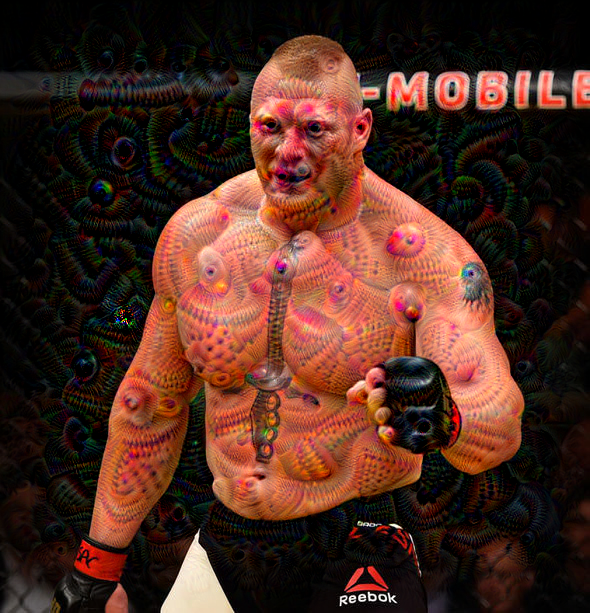

In [21]:
display(Image(result_prefix + '.png'))

Now Brock Lesnar seems from an Ayahuasca dream